In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set a seed for reproducibility
SEED = 222
np.random.seed(SEED)

# split the data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [3]:
def logreg_fit(csv_file):
    df = pd.read_csv('../data/processed/{}'.format(csv_file))
    df.drop('Unnamed: 0', axis=1, inplace=True)
    # check if there are empty values
    assert df.isna().sum().sum()==0, 'There are missing values'
    y = df.OUTPUT_LABEL.values
    X = df.drop(['OUTPUT_LABEL'], axis=1).values
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
    scaler = MinMaxScaler()
    Xtrain_scaled = scaler.fit_transform(Xtrain)
    Xtest_scaled = scaler.transform(Xtest)
    start_time = time.monotonic()
    clf = LogisticRegression(C=100, solver='liblinear', random_state=SEED, class_weight='balanced', max_iter=200)
    clf.fit(Xtrain_scaled,ytrain)
    yscore = clf.predict(Xtest_scaled)
    ypred = clf.predict_proba(Xtest_scaled)[:,1]
    roc_auc = roc_auc_score(ytest, ypred)
    print("File name:{}".format(csv_file))
    print("Confusion matrix")
    print(confusion_matrix(ytest, yscore))
    print("Classification report")
    print(classification_report(ytest, yscore))
    print("AUROC {}".format(roc_auc))
    print("Time elapsed {}s".format(time.monotonic()-start_time))
    fpr, tpr, _ = roc_curve(ytest, ypred)
    fig, ax = plt.subplots(1, 2, figsize=(12,4))    
    ax[0].plot(fpr, tpr, label='Area = %0.3f' % roc_auc)
    ax[0].plot([0, 1], [0, 1],'r--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right")
    
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    ave_prec_rec = average_precision_score(ytest, ypred)
    ax[1].plot(recall, precision, label='AP = %0.3f' % ave_prec_rec)
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right")
    
    return Xtrain_scaled, Xtest_scaled, ytrain, ytest
    
    start_time = time.monotonic()

File name:feat_select_fitting_030220.csv
Confusion matrix
[[4819 2290]
 [ 153  381]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80      7109
         1.0       0.14      0.71      0.24       534

    accuracy                           0.68      7643
   macro avg       0.56      0.70      0.52      7643
weighted avg       0.91      0.68      0.76      7643

AUROC 0.7459848069361884
Time elapsed 10.59296851399995s


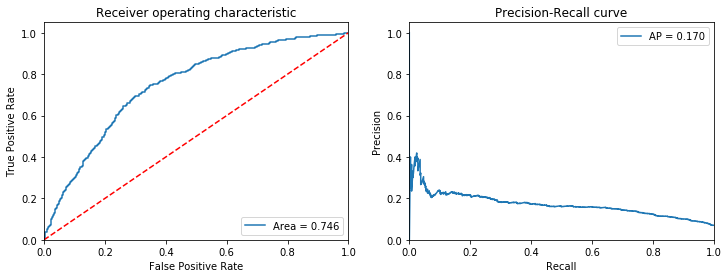

In [70]:
csv_file = 'feat_select_fitting_030220.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [16]:
def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        ap = average_precision_score(y, P.loc[:, m])
        print("%-26s: %.3f, %.3f" % (m, score, ap))
    print("Done.\n")

def test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled):
    
    Cs = np.logspace(-4, 4, 9)
    PL = np.zeros((ytest.shape[0], len(Cs)))
    PL = pd.DataFrame(PL)


    ave_train_scores=[]
    test_scores=[]

    logreg_models = {}
    cols = list()
    for i in range(len(Cs)):
        clf = LogisticRegression(C=Cs[i], random_state=SEED, solver='liblinear', class_weight='balanced')
        clf.fit(Xtrain_scaled, ytrain)
        PL.iloc[:, i] = clf.predict_proba(Xtest_scaled)[:, 1]
        cols.append(Cs[i])
        logreg_models[Cs[i]] = clf

    PL.columns = cols
    score_models(PL, ytest) 
    
    return PL

In [71]:
PL = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.683, 0.144
0.001                     : 0.700, 0.153
0.01                      : 0.729, 0.165
0.1                       : 0.745, 0.168
1.0                       : 0.747, 0.170
10.0                      : 0.746, 0.170
100.0                     : 0.746, 0.170
1000.0                    : 0.746, 0.170
10000.0                   : 0.746, 0.170
Done.



In [14]:
def plot_roc_pr(PL, ytest):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))    

    for column in PL.columns:
        roc_auc = roc_auc_score(ytest, PL[column])
        fpr, tpr, _ = roc_curve(ytest, PL[column])
        ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

        precision, recall, _ = precision_recall_curve(ytest, PL[column])
        ave_prec_rec = average_precision_score(ytest, PL[column])
        ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="C: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="C: AP")

    plt.savefig('../reports/figures/roc_pr_'+csv_file+'.png')

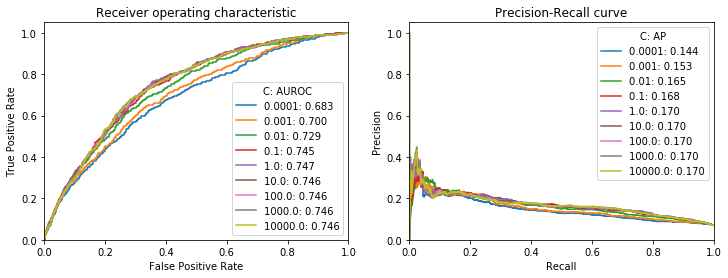

In [15]:
plot_roc_pr(PL, ytest)

In [73]:
Xtrain_scaled.shape

(30568, 314)

File name:df_0.005_0.005.csv
Confusion matrix
[[4896 2213]
 [ 212  322]]
Classification report
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80      7109
         1.0       0.13      0.60      0.21       534

    accuracy                           0.68      7643
   macro avg       0.54      0.65      0.51      7643
weighted avg       0.90      0.68      0.76      7643

AUROC 0.6940653378662802
Time elapsed 6.772790194999743s


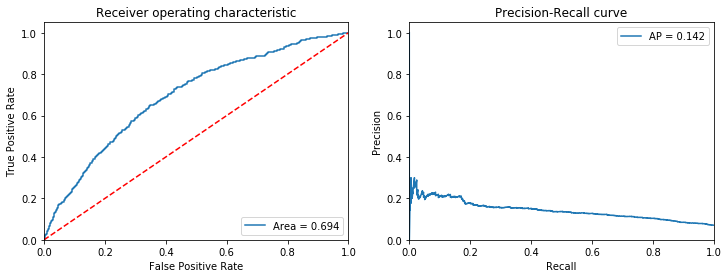

In [17]:
csv_file = 'df_0.005_0.005.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [18]:
PL = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.681, 0.142
0.001                     : 0.684, 0.144
0.01                      : 0.689, 0.143
0.1                       : 0.691, 0.141
1.0                       : 0.693, 0.144
10.0                      : 0.694, 0.143
100.0                     : 0.694, 0.142
1000.0                    : 0.694, 0.142
10000.0                   : 0.694, 0.142
Done.



,0.0001,0.0010,0.0100,0.1000,1.0000,10.0000,100.0000,1000.0000,10000.0000
0,0.486017,0.412656,0.339193,0.286923,0.261057,0.259540,0.260637,0.259193,0.260364
1,0.563141,0.749676,0.880106,0.909321,0.908988,0.902299,0.901586,0.903154,0.904332
2,0.482117,0.394370,0.304944,0.292287,0.343372,0.360083,0.364852,0.367286,0.368055
3,0.548833,0.682149,0.771966,0.785260,0.784893,0.785905,0.780359,0.773694,0.772188
4,0.484210,0.401417,0.346584,0.365124,0.381353,0.393204,0.398737,0.402186,0.403207
...,...,...,...,...,...,...,...,...,...
7638,0.471240,0.339085,0.211056,0.161080,0.150593,0.147524,0.145615,0.143729,0.143230
7639,0.500900,0.466341,0.393698,0.359997,0.333121,0.317707,0.312016,0.307126,0.304390
7640,0.479206,0.375249,0.293973,0.307562,0.329805,0.341692,0.348242,0.350548,0.350395
7641,0.503883,0.483495,0.432727,0.411804,0.420986,0.421703,0.415617,0.413510,0.412906


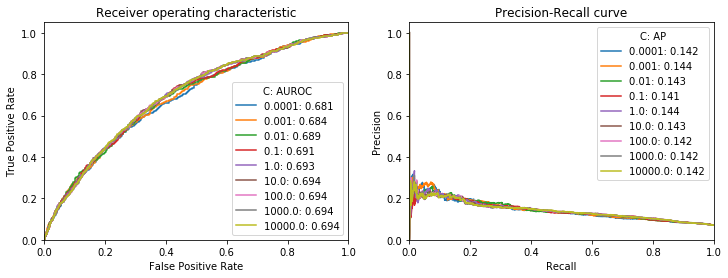

In [21]:
plot_roc_pr(PL, ytest)

File name:df_0.0025_0.0025.csv
Confusion matrix
[[4802 2307]
 [ 182  352]]
Classification report
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.79      7109
         1.0       0.13      0.66      0.22       534

    accuracy                           0.67      7643
   macro avg       0.55      0.67      0.51      7643
weighted avg       0.91      0.67      0.75      7643

AUROC 0.7145257659884632
Time elapsed 7.331987425000079s


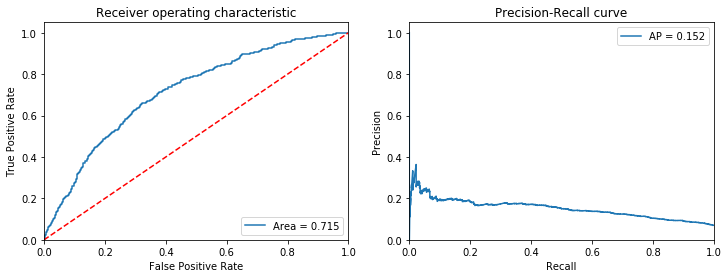

In [22]:
csv_file = 'df_0.0025_0.0025.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [23]:
PL = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.684, 0.142
0.001                     : 0.695, 0.147
0.01                      : 0.709, 0.150
0.1                       : 0.713, 0.150
1.0                       : 0.714, 0.153
10.0                      : 0.715, 0.153
100.0                     : 0.715, 0.152
1000.0                    : 0.715, 0.151
10000.0                   : 0.715, 0.151
Done.



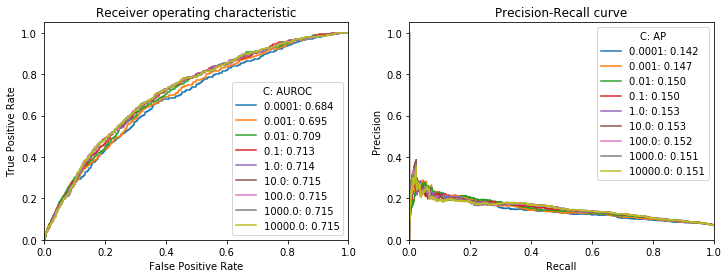

In [24]:
plot_roc_pr(PL, ytest)

File name:df_0.001_0.001.csv
Confusion matrix
[[4825 2284]
 [ 182  352]]
Classification report
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80      7109
         1.0       0.13      0.66      0.22       534

    accuracy                           0.68      7643
   macro avg       0.55      0.67      0.51      7643
weighted avg       0.91      0.68      0.76      7643

AUROC 0.7201015961725997
Time elapsed 13.491122894s


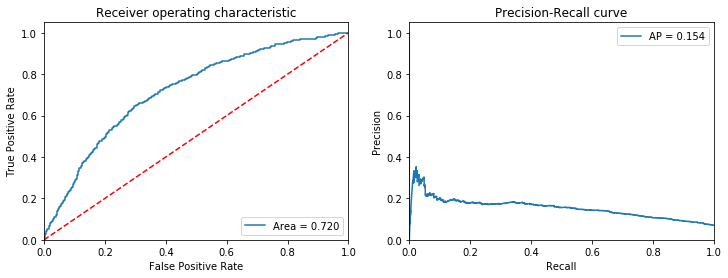

In [25]:
csv_file = 'df_0.001_0.001.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [26]:
PL = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.683, 0.143
0.001                     : 0.696, 0.148
0.01                      : 0.712, 0.153
0.1                       : 0.717, 0.154
1.0                       : 0.719, 0.156
10.0                      : 0.720, 0.155
100.0                     : 0.720, 0.154
1000.0                    : 0.720, 0.154
10000.0                   : 0.720, 0.154
Done.



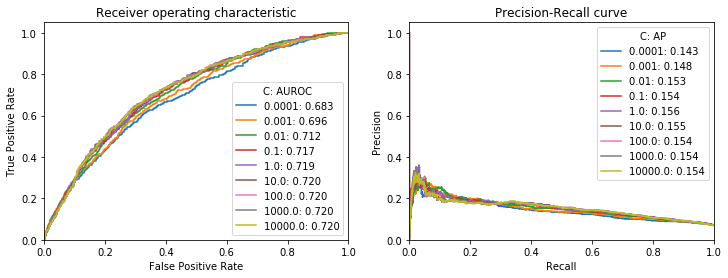

In [27]:
plot_roc_pr(PL, ytest)

File name:df_0.0005_0.0005.csv
Confusion matrix
[[4843 2266]
 [ 186  348]]
Classification report
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80      7109
         1.0       0.13      0.65      0.22       534

    accuracy                           0.68      7643
   macro avg       0.55      0.67      0.51      7643
weighted avg       0.91      0.68      0.76      7643

AUROC 0.7233601127019977
Time elapsed 9.504315143999975s


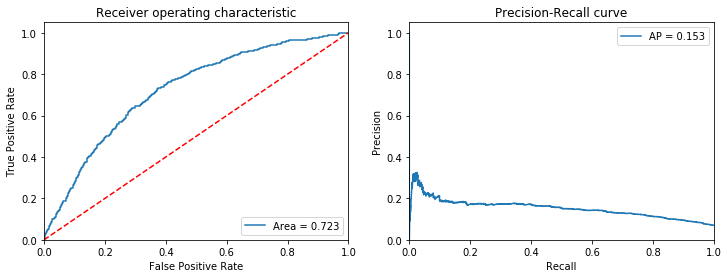

In [28]:
csv_file = 'df_0.0005_0.0005.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [29]:
PL = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.684, 0.143
0.001                     : 0.697, 0.149
0.01                      : 0.715, 0.154
0.1                       : 0.722, 0.154
1.0                       : 0.723, 0.154
10.0                      : 0.723, 0.153
100.0                     : 0.723, 0.153
1000.0                    : 0.724, 0.153
10000.0                   : 0.724, 0.153
Done.



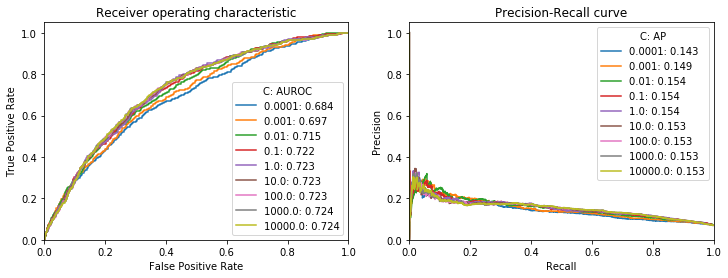

In [30]:
plot_roc_pr(PL, ytest)

File name:df_p09.csv
Confusion matrix
[[4793 2316]
 [ 154  380]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.80      7109
         1.0       0.14      0.71      0.24       534

    accuracy                           0.68      7643
   macro avg       0.55      0.69      0.52      7643
weighted avg       0.91      0.68      0.76      7643

AUROC 0.7469028287716735
Time elapsed 11.005107011000291s


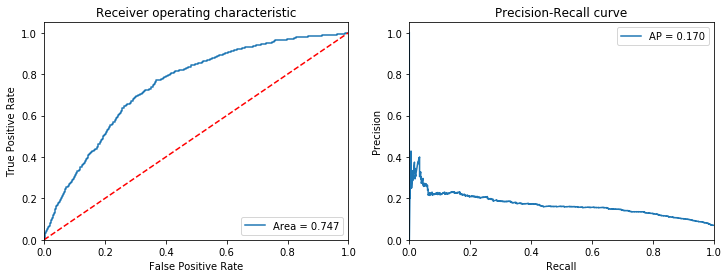

In [31]:
csv_file = 'df_p09.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [32]:
PL = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.682, 0.142
0.001                     : 0.700, 0.152
0.01                      : 0.729, 0.164
0.1                       : 0.745, 0.168
1.0                       : 0.747, 0.170
10.0                      : 0.747, 0.170
100.0                     : 0.747, 0.170
1000.0                    : 0.747, 0.169
10000.0                   : 0.747, 0.169
Done.



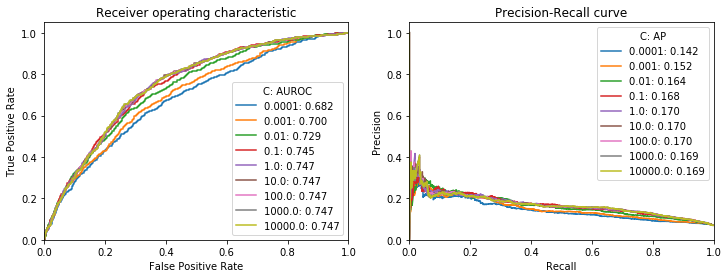

In [33]:
plot_roc_pr(PL, ytest)

File name:df_p09_sorted.csv
Confusion matrix
[[4793 2316]
 [ 154  380]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.80      7109
         1.0       0.14      0.71      0.24       534

    accuracy                           0.68      7643
   macro avg       0.55      0.69      0.52      7643
weighted avg       0.91      0.68      0.76      7643

AUROC 0.7457872412614068
Time elapsed 6.68257417300083s


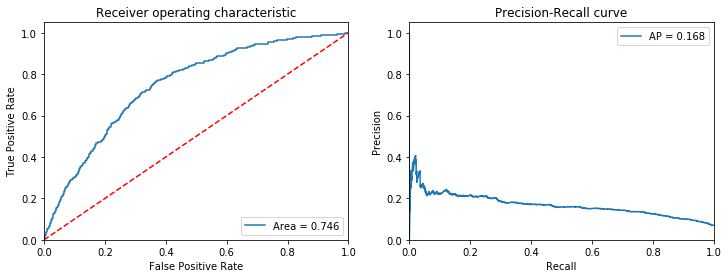

In [41]:
csv_file = 'df_p09_sorted.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [42]:
PL = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.682, 0.142
0.001                     : 0.699, 0.152
0.01                      : 0.729, 0.164
0.1                       : 0.745, 0.169
1.0                       : 0.746, 0.169
10.0                      : 0.746, 0.169
100.0                     : 0.746, 0.168
1000.0                    : 0.746, 0.168
10000.0                   : 0.746, 0.168
Done.



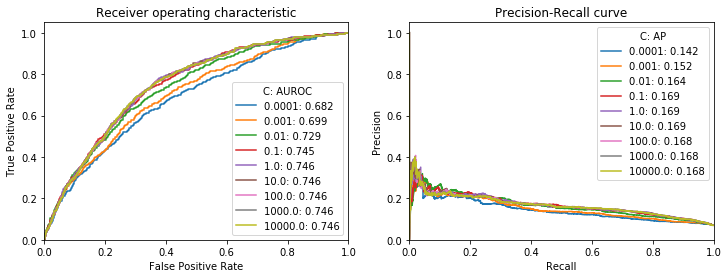

In [43]:
plot_roc_pr(PL, ytest)

File name:df_p095_sorted.csv
Confusion matrix
[[4804 2305]
 [ 153  381]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80      7109
         1.0       0.14      0.71      0.24       534

    accuracy                           0.68      7643
   macro avg       0.56      0.69      0.52      7643
weighted avg       0.91      0.68      0.76      7643

AUROC 0.7472436954158967
Time elapsed 7.307518986999639s


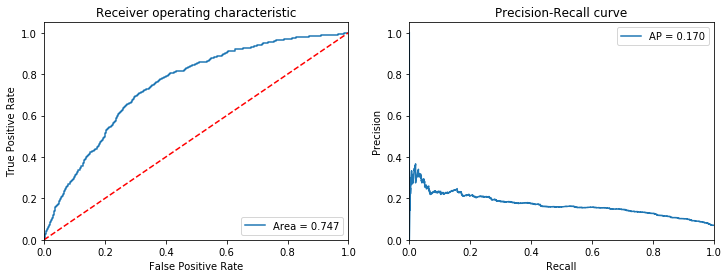

In [44]:
csv_file = 'df_p095_sorted.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

File name:df_p095_tu0005_sorted.csv
Confusion matrix
[[4831 2278]
 [ 179  355]]
Classification report
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80      7109
         1.0       0.13      0.66      0.22       534

    accuracy                           0.68      7643
   macro avg       0.55      0.67      0.51      7643
weighted avg       0.91      0.68      0.76      7643

AUROC 0.7235795423114552
Time elapsed 7.087216068000998s


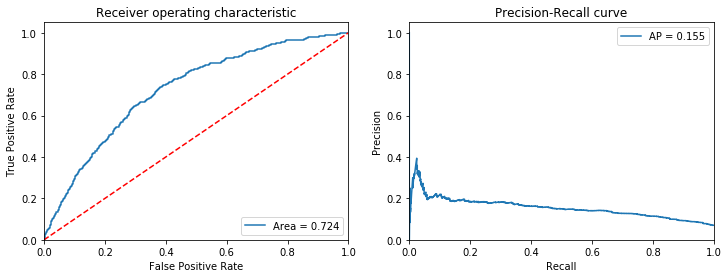

In [47]:
csv_file = 'df_p095_tu0005_sorted.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

File name:df_p095_tu0001_sorted.csv
Confusion matrix
[[4802 2307]
 [ 154  380]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80      7109
         1.0       0.14      0.71      0.24       534

    accuracy                           0.68      7643
   macro avg       0.56      0.69      0.52      7643
weighted avg       0.91      0.68      0.76      7643

AUROC 0.746579611327731
Time elapsed 8.124389058000816s


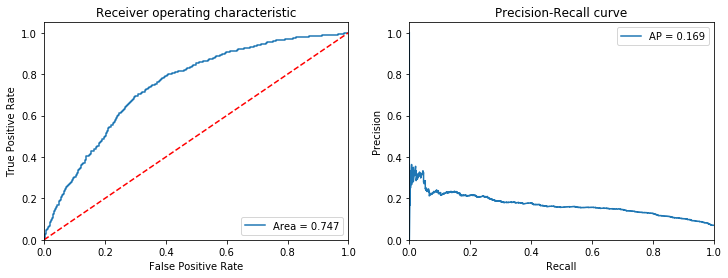

In [48]:
csv_file = 'df_p095_tu0001_sorted.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [49]:
PL = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.683, 0.143
0.001                     : 0.699, 0.151
0.01                      : 0.728, 0.163
0.1                       : 0.744, 0.168
1.0                       : 0.747, 0.170
10.0                      : 0.747, 0.170
100.0                     : 0.747, 0.169
1000.0                    : 0.747, 0.169
10000.0                   : 0.747, 0.169
Done.



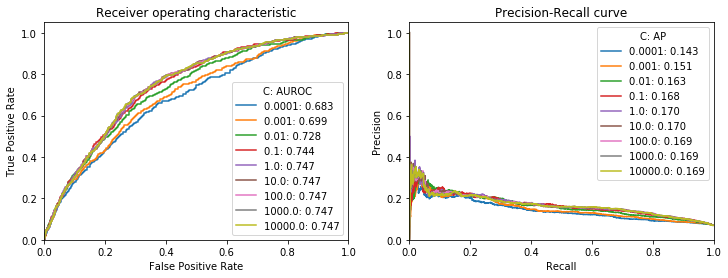

In [50]:
plot_roc_pr(PL, ytest)

File name:df_p095_tu0001_cv09.csv
Confusion matrix
[[4799 2310]
 [ 166  368]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.68      0.79      7109
         1.0       0.14      0.69      0.23       534

    accuracy                           0.68      7643
   macro avg       0.55      0.68      0.51      7643
weighted avg       0.91      0.68      0.76      7643

AUROC 0.7436598540753584
Time elapsed 11.214961539000797s


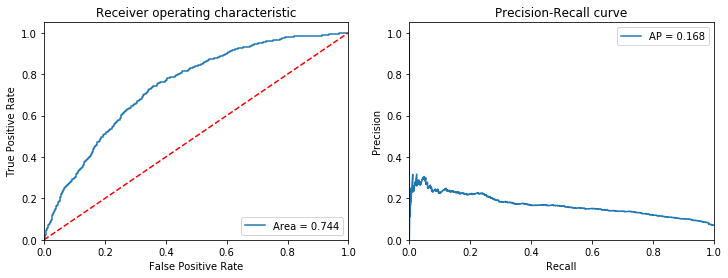

In [51]:
csv_file = 'df_p095_tu0001_cv09.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

File name:df_p095_tu0001_cv095.csv
Confusion matrix
[[4786 2323]
 [ 157  377]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79      7109
         1.0       0.14      0.71      0.23       534

    accuracy                           0.68      7643
   macro avg       0.55      0.69      0.51      7643
weighted avg       0.91      0.68      0.76      7643

AUROC 0.7430568836359248
Time elapsed 5.620898764000231s


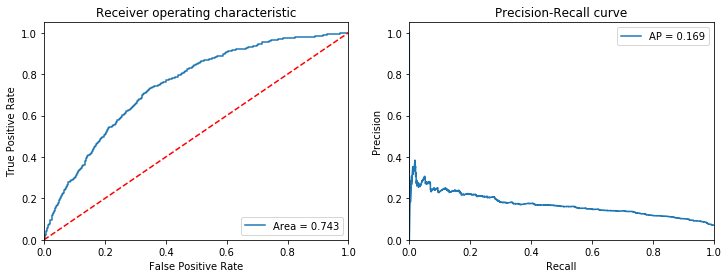

In [52]:
csv_file = 'df_p095_tu0001_cv095.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [53]:
PL = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.679, 0.140
0.001                     : 0.696, 0.148
0.01                      : 0.726, 0.162
0.1                       : 0.741, 0.167
1.0                       : 0.742, 0.169
10.0                      : 0.743, 0.169
100.0                     : 0.743, 0.169
1000.0                    : 0.743, 0.169
10000.0                   : 0.744, 0.169
Done.



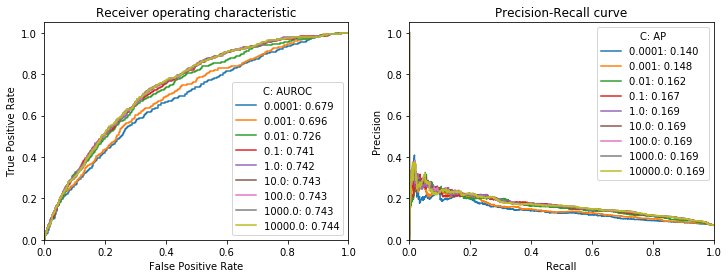

In [54]:
plot_roc_pr(PL, ytest)

File name:df_p095_tu0001_cv0975.csv
Confusion matrix
[[4802 2307]
 [ 157  377]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80      7109
         1.0       0.14      0.71      0.23       534

    accuracy                           0.68      7643
   macro avg       0.55      0.69      0.52      7643
weighted avg       0.91      0.68      0.76      7643

AUROC 0.7437478366558611
Time elapsed 7.9564812229982635s


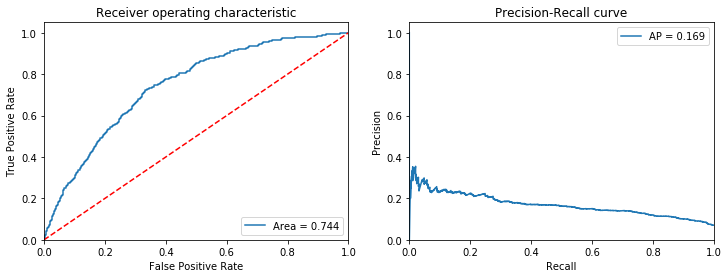

In [55]:
csv_file = 'df_p095_tu0001_cv0975.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [56]:
PL = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.679, 0.141
0.001                     : 0.696, 0.148
0.01                      : 0.727, 0.162
0.1                       : 0.742, 0.167
1.0                       : 0.743, 0.169
10.0                      : 0.744, 0.169
100.0                     : 0.744, 0.169
1000.0                    : 0.744, 0.169
10000.0                   : 0.744, 0.168
Done.



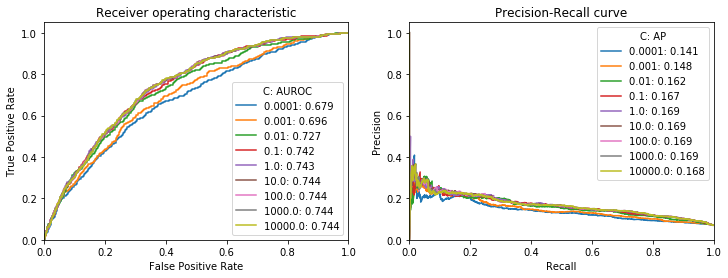

In [57]:
plot_roc_pr(PL, ytest)

File name:df_p095_tu0001_cv098.csv
Confusion matrix
[[4803 2306]
 [ 157  377]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80      7109
         1.0       0.14      0.71      0.23       534

    accuracy                           0.68      7643
   macro avg       0.55      0.69      0.52      7643
weighted avg       0.91      0.68      0.76      7643

AUROC 0.743744148763265
Time elapsed 6.861598604999017s


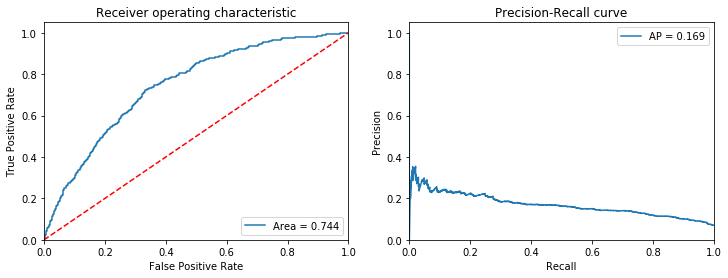

In [58]:
csv_file = 'df_p095_tu0001_cv098.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [59]:
PL = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.680, 0.141
0.001                     : 0.696, 0.148
0.01                      : 0.727, 0.162
0.1                       : 0.742, 0.167
1.0                       : 0.743, 0.169
10.0                      : 0.744, 0.169
100.0                     : 0.744, 0.169
1000.0                    : 0.744, 0.169
10000.0                   : 0.744, 0.168
Done.



File name:df_p095_tu0001_cv099.csv
Confusion matrix
[[4811 2298]
 [ 160  374]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80      7109
         1.0       0.14      0.70      0.23       534

    accuracy                           0.68      7643
   macro avg       0.55      0.69      0.51      7643
weighted avg       0.91      0.68      0.76      7643

AUROC 0.7437762861130297
Time elapsed 7.2597948419970635s


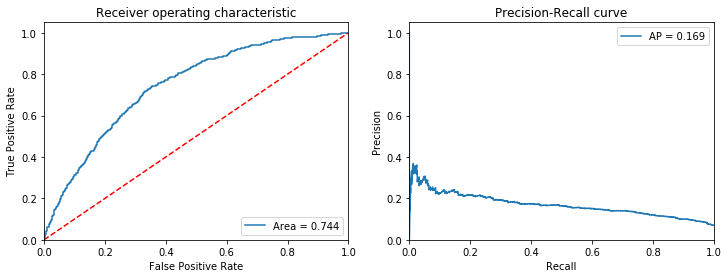

In [74]:
csv_file = 'df_p095_tu0001_cv099.csv'
Xtrain_scaled, Xtest_scaled, ytrain, ytest = logreg_fit(csv_file)

In [61]:
PL = test_c_vals(Xtrain_scaled, ytrain, Xtest_scaled)

Scoring models.
0.0001                    : 0.681, 0.141
0.001                     : 0.698, 0.150
0.01                      : 0.727, 0.162
0.1                       : 0.741, 0.167
1.0                       : 0.743, 0.169
10.0                      : 0.744, 0.170
100.0                     : 0.744, 0.169
1000.0                    : 0.744, 0.169
10000.0                   : 0.744, 0.169
Done.



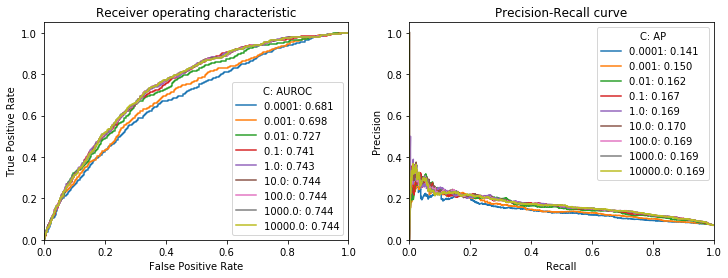

In [69]:
plot_roc_pr(PL, ytest)
plt.savefig('../reports/figures/logreg_after_feat_select.png', format='png')

Confusion matrix
[[4804 2305]
 [ 167  367]]
Normalized confusion matrix
[[0.68 0.32]
 [0.31 0.69]]


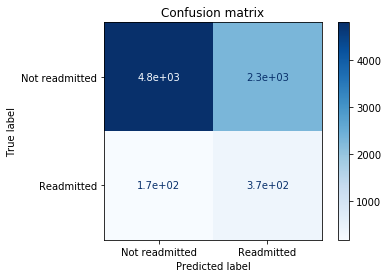

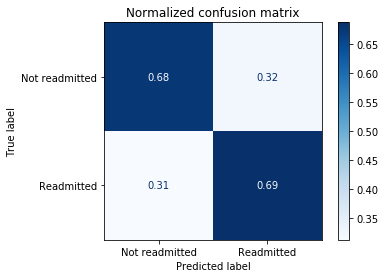

In [90]:
from sklearn.metrics import plot_confusion_matrix

clf = LogisticRegression(C=10, solver='liblinear', random_state=SEED, class_weight='balanced', max_iter=200)
clf.fit(Xtrain_scaled,ytrain)
class_names = ['Not readmitted', 'Readmitted']
#yscore = clf.predict(Xtest_scaled)
#ypred = clf.predict_proba(Xtest_scaled)[:,1]

np.set_printoptions(precision=2)

titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, Xtest_scaled, ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    plt.savefig('../reports/figures/{}_conf_matrix.png'.format(title), format='png')

plt.show()

In [91]:
yscore = clf.predict(Xtest_scaled)
#print("Classification report")

print(classification_report(ytest, yscore))

              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80      7109
         1.0       0.14      0.69      0.23       534

    accuracy                           0.68      7643
   macro avg       0.55      0.68      0.51      7643
weighted avg       0.91      0.68      0.76      7643



In [93]:
coefficients = np.squeeze(clf.coef_).T.tolist()
df = pd.read_csv('../data/processed/df_p095_tu0001_cv099.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
features = df.drop(['OUTPUT_LABEL'], axis=1).columns.tolist()
coef_df = pd.DataFrame({'feature':features, 'coefficient':coefficients})
coef_df.sort_values(by='coefficient', ascending=False, inplace=True)
coef_df.head(20)


,feature,coefficient
13,DISCHARGE_LOCATION_LONG TERM CARE HOSPITAL,2.329449
14,DISCHARGE_LOCATION_REHAB/DISTINCT PART HOSP,2.149062
16,DISCHARGE_LOCATION_SNF,2.115444
12,DISCHARGE_LOCATION_LEFT AGAINST MEDICAL ADVI,1.895637
10,DISCHARGE_LOCATION_HOME HEALTH CARE,1.849443
9,DISCHARGE_LOCATION_HOME,1.553079
74,Mean_RDW,1.251504
15,DISCHARGE_LOCATION_SHORT TERM HOSPITAL,1.110796
47,SUBSECTIONHEADER_Pulmonary,0.941898
8,DISCHARGE_LOCATION_DISCH-TRAN TO PSYCH HOSP,0.897861


In [95]:
coef_df.tail(20)

,feature,coefficient
2,AGE,-0.469174
18,ETHNICITY_OTHER,-0.471666
71,Mean_Phosphate,-0.511147
27,CURR_SERVICE_TRAUM,-0.511441
124,coronari,-0.549657
209,tissu,-0.562536
99,Var_Urea Nitrogen,-0.594299
170,mcc,-0.595241
92,Var_PTT,-0.606482
80,Var_Bicarbonate,-0.609187


In [106]:
X = np.array([[ 1.,  0.,  2.],
              [ 2.,  0.,  0.],
              [ 0.,  1., -1.]])

In [109]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)
X_scaled

array([[ 0.  , -0.71,  1.34],
       [ 1.22, -0.71, -0.27],
       [-1.22,  1.41, -1.07]])

In [110]:
min_max_scaler = preprocessing.MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)
X_minmax

array([[0.5 , 0.  , 1.  ],
       [1.  , 0.  , 0.33],
       [0.  , 1.  , 0.  ]])